<a href="https://colab.research.google.com/github/tbbcoach/DS-Unit-2-Kaggle-Challenge/blob/main/Copy_of_LS_DS_221_assignments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    #DATA_PATH = 'kaggle competitions download -c dspt12-water-pump-challenge'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    
# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Decision Trees

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

In [33]:
import pandas as pd


# Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. **We recommend that you choose a username that's based on your name, since you might include it in your resume in the future.** Go to our Kaggle InClass competition website (the URL is in Slack). Go to the **Rules** page. Accept the rules of the competition. Notice that the **Rules** page also has instructions for the Submission process. The **Data** page has feature definitions.

# I. Wrangle Data

In [34]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             

    return df

**Task 1:** Using the `wrangle` function above, read the `train_features.csv` and  `train_labels.csv` files into the DataFrame `df`. Next, use the same function to read the test set `test_features.csv` into the DataFrame `X_test`.

In [32]:
from google.colab import files
upload = files.upload()

Saving test_features.csv to test_features (1).csv
Saving train_features.csv to train_features (1).csv
Saving train_labels.csv to train_labels (1).csv


In [103]:
df = wrangle('train_features.csv', 'train_labels.csv')
X_test = wrangle('test_features.csv')

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
Float64Index: 47519 entries, 454.0 to 23812.0
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             14189 non-null  float64
 1   gps_height             31245 non-null  float64
 2   longitude              46086 non-null  float64
 3   latitude               46086 non-null  float64
 4   num_private            617 non-null    float64
 5   basin                  47519 non-null  object 
 6   region                 47519 non-null  object 
 7   region_code            47519 non-null  int64  
 8   district_code          47500 non-null  float64
 9   population             30472 non-null  float64
 10  public_meeting         44831 non-null  object 
 11  scheme_management      44417 non-null  object 
 12  permit                 45080 non-null  object 
 13  construction_year      31017 non-null  float64
 14  extraction_type        47519 non-null  object 

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [102]:
target = 'status_group'

X = df.drop(columns=[target])
y = df[target]

X.shape, y.shape, X_test.shape

((47519, 27), (47519,), (11880, 28))

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((35639, 27), (11880, 27), (35639,), (11880,))

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [38]:
y_train.value_counts(normalize=True)
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [39]:
from sklearn.metrics import accuracy_score

baseline_acc = accuracy_score(y_train, y_pred)
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425797581301384


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_dt`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `DecisionTreeClassifier`.

In [121]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


model_dt = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(max_depth=15, random_state=91)
) 

model_dt.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_class',
                                     'management', 'management_group',
                                     'payment', 'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'waterpoint_type'],
                               drop_invariant=False, ha...
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=15,
        

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_dt`.

In [122]:
training_acc = model_dt.score(X_train, y_train)
val_acc = model_dt.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8278290636662083
Validation Accuracy Score: 0.7603535353535353


# VI. Tune Model

**Task 8:** Is there a large difference between your training and validation accuracy? If so, experiment with different setting for `max_depth` in your `DecisionTreeClassifier` to reduce the amount of overfitting in your model.

In [129]:
y_pred = model_dt.predict(X_test)

#X_test.drop('waterpoint_type_group', axis=1, inplace=True)
predictions = pd.DataFrame(y_pred)
predictions.index = X_test.index
predictions.columns = ['status_group']
predictions.to_csv('predictions.csv')

In [114]:
X_test.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,NaN,NaN,31.985658,-3.596360,NaN,Lake Tanganyika,Shinyanga,17,5.0,NaN,True,WUG,True,NaN,other,other,wug,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other
14530,NaN,NaN,32.832815,-4.944937,NaN,Lake Tanganyika,Tabora,14,6.0,NaN,True,VWC,True,NaN,india mark ii,handpump,vwc,user-group,never pay,never pay,milky,milky,insufficient,shallow well,shallow well,groundwater,hand pump
62607,10.0,1675.0,35.488289,-4.242048,NaN,Internal,Manyara,21,1.0,148.0,True,Water Board,True,2008.0,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe
46053,NaN,NaN,33.140828,-9.059386,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,False,VWC,False,NaN,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,seasonal,shallow well,shallow well,groundwater,hand pump
47083,50.0,1109.0,34.217077,-4.430529,NaN,Internal,Singida,13,1.0,235.0,True,WUA,True,2011.0,mono,motorpump,wua,user-group,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple


In [128]:
# Use this cell to experiment and then change 
# your model hyperparameters in Task 6csv
ce.OneHotEncoder(use_cat_names=True),
SimpleImputer(strategy='mean'),
DecisionTreeClassifier(max_depth=1, random_state=91)


model_dt.fit(X_train, y_train)

training_acc = model_dt.score(X_train, y_train)
val_acc = model_dt.score(X_val, y_val)

eval = training_acc - val_acc

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)
print(eval)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Training Accuracy Score: 0.8278290636662083
Validation Accuracy Score: 0.7603535353535353
0.067475528312673


# VII. Communicate Results

**Task 9 `stretch goal`:** Create a horizontal barchart that shows the the 10 most important features for model_dt, sorted by value.

**Note:** [`DecisionTreeClassifier.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreecla#sklearn.tree.DecisionTreeClassifier.feature_importances_) returns values that are different from [`LogisticRegression.coef_`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). All the values will be positive, and they will sum to `1`.

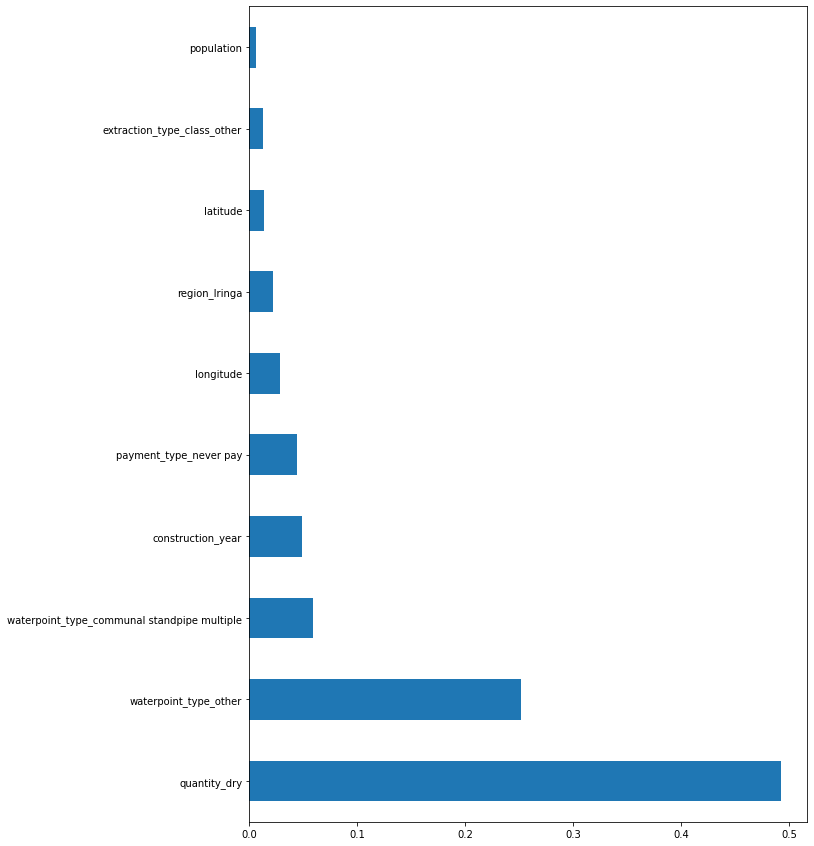

In [99]:
import matplotlib.pyplot as plt


model = model_dt.named_steps['decisiontreeclassifier']
encoder = model_dt.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,15))
importances.sort_values(ascending=False).head(10).plot.barh()